In [1]:
# Standard imports
import numpy as np
import yaml
import toml
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline  
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 20]

# bolo-calc import
from bolo import Top

import BoloCalcVariation as bcv

In [2]:
# Set up inputs

# yaml files to use
telescopes = dict.fromkeys(['CHLAT_20210401.yaml', 'SPLAT_20210401.yaml', 'SAT_pole_20210401.yaml'])

#Make dictionary of nominal PSATs. Enter values in pW. 
psat ={}
psat['SAT_pole_20210401'] = {'LF_1': 1.40, 'LF_2': 6.13, 'MF1_1': 7.40, 'MF1_2': 12.25, 'MF2_1': 7.65, 'MF2_2': 13.30, 'UHF_1': 29.88, 'UHF_2': 39.03}
psat['SPLAT_20210401'] = {'ULF': 0.42, 'LF_1': 0.69, 'LF_2': 4.32, 'MF_1': 4.65, 'MF_2': 11.49, 'UHF_1': 29.31, 'UHF_2': 40.02}
psat['CHLAT_20210401'] = {'LF_1': 0.72, 'LF_2': 3.84, 'MF_1': 4.47, 'MF_2': 13.95, 'UHF_1': 41.52, 'UHF_2': 60.78}

# input parameter to vary
xparam_name = 'elevation'
xparam_vec = np.arange(30,70,1)
# in_param possible values:
#  'band_response', 'num_wafer_per_optics_tube', 'num_optics_tube', 
#  'waist_factor', 'psat', 'psat_factor', 'carrier_index', 'Tc', 'Tc_fraction', 
#  'G', 'Flink', 'Yield', 'response_factor', 'bolo_resistance', 'read_frac'

# output parameter to plot and save.
yparam_name = 'opt_power' #
# out_param possible values:
#  'effic', 'opt_power','tel_rj_temp','sky_rj_temp','NEP_bolo',
#  'NEP_read','NEP_ph','NEP','NET','NET_corr','corr_fact','NET_arr'

# Run CHLAT

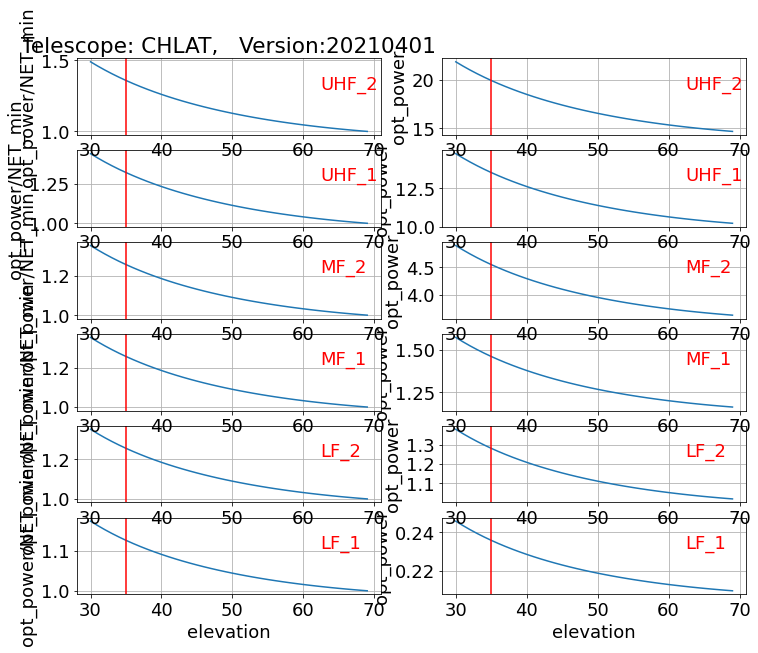

In [4]:
yaml_file = list(telescopes.keys())[0]
dd = yaml.safe_load(open(yaml_file))
# location of atmosphere file
dd['sim_config']['config_dir'] = '../../bolo-calc/config'
dd['version']['yaml']=yaml_file

channel_dict = bcv.vary_param_at_fixed_psat(xparam_name,xparam_vec,yparam_name,dd,psat)[1]
telescopes[yaml_file] = channel_dict

In [5]:
# Run SPLAT

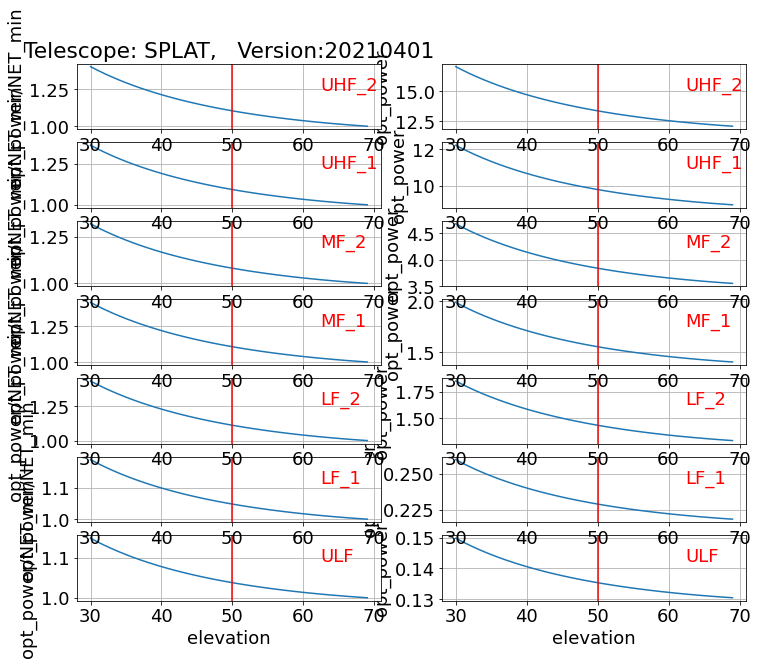

In [6]:
yaml_file = list(telescopes.keys())[1]
dd = yaml.safe_load(open(yaml_file))
# location of atmosphere file
dd['sim_config']['config_dir'] = '../../bolo-calc/config'
dd['version']['yaml']=yaml_file

channel_dict = bcv.vary_param_at_fixed_psat(xparam_name,xparam_vec,yparam_name,dd,psat)[1]
telescopes[yaml_file] = channel_dict

# Run SAT (at Pole)

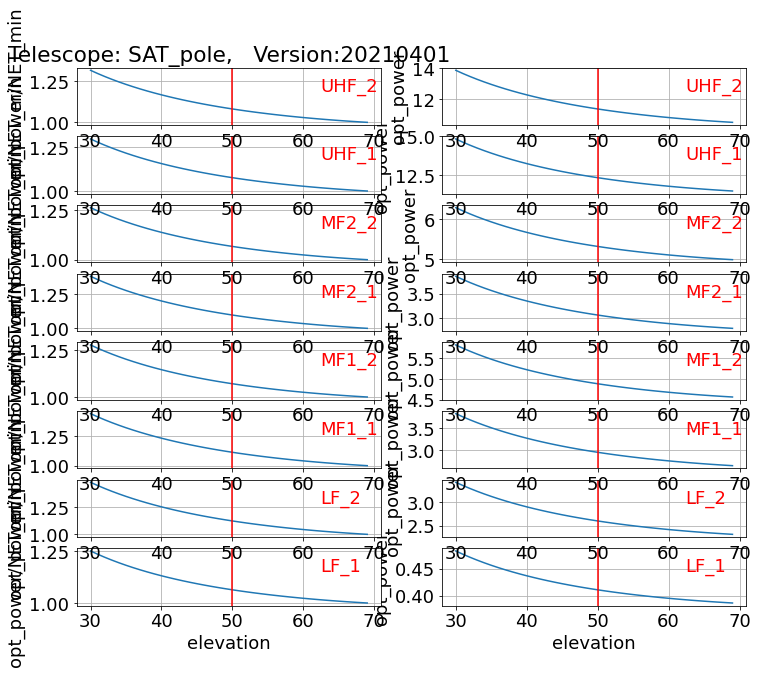

In [8]:
yaml_file = list(telescopes.keys())[2]
dd = yaml.safe_load(open(yaml_file))
# location of atmosphere file
dd['sim_config']['config_dir'] = '../../bolo-calc/config'
dd['version']['yaml']=yaml_file

version_date, channel_dict = bcv.vary_param_at_fixed_psat(xparam_name,xparam_vec,yparam_name,dd,psat)
telescopes[yaml_file] = channel_dict

# Write all three (CHLAT, SPLAT, SAT) to toml file.

In [10]:
telescopes["runtime"] = datetime.today().strftime('%Y/%m/%d %H:%M:%S')
telescopes["input_id"] = version_date
telescopes["variation"] = yparam_name + '_v_' + xparam_name

output_file_name = telescopes['variation'] + '.toml'

with open('outputs/' + output_file_name, "w") as toml_file:
    toml.dump(telescopes, toml_file, encoder=toml.TomlNumpyEncoder())